In [27]:
import pandas as pd

In [28]:
data = pd.read_csv('step.csv')
data.head()

,Date,Step,exam_week
0,22/09/2024,9242,0
1,23/09/2024,6059,0
2,24/09/2024,7079,0
3,25/09/2024,4183,0
4,26/09/2024,6798,0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_41204\1947176511.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Step'].fillna(df['Step'].mean(), inplace=True)


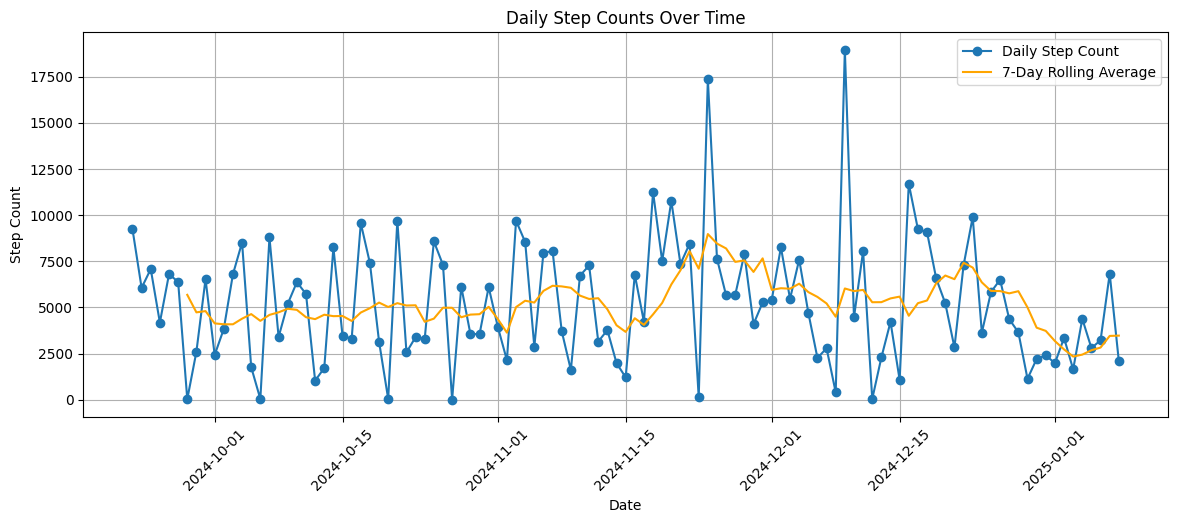

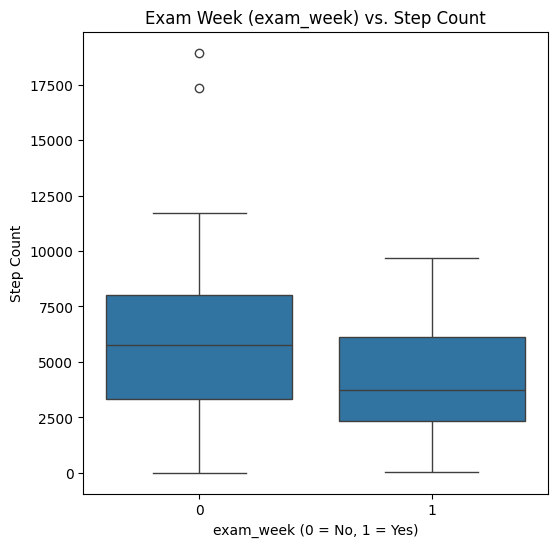

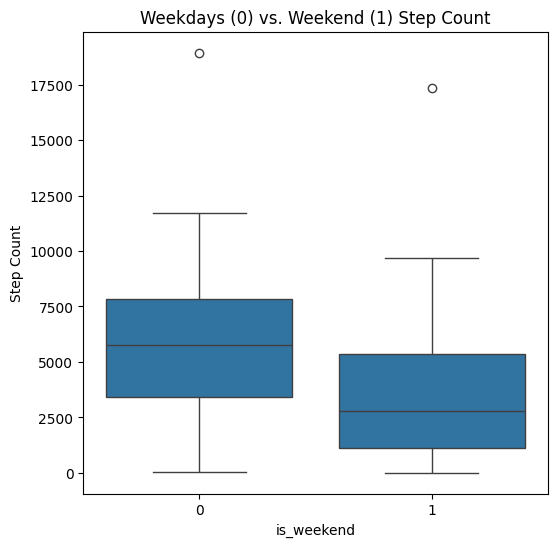

T-test (Exam vs. Non-exam): t_stat = -2.604, p_val = 0.011
Reject the null hypothesis: Significant difference between exam and non-exam weeks.
T-test (Weekday vs. Weekend): t_stat = 2.710, p_val = 0.009
Reject the null hypothesis: Significant difference between weekday and weekend steps.

--- Random Forest Results ---
MSE: 12175012.713162212
R2: 0.10057244263760357

--- Linear Regression Results ---
MSE: 14852483.959176632
R2: -0.09722541428843856

Data processing complete. Results saved to 'processed_steps.csv'.


In [29]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Read the CSV file into a DataFrame
df = pd.read_csv('step.csv')

# Convert the 'Date' column from string to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Convert the 'Step' column to numeric, coercing invalid values to NaN
df['Step'] = pd.to_numeric(df['Step'], errors='coerce')

# Ensure 'exam_week' is an integer type
df['exam_week'] = df['exam_week'].astype(int)

# Check for missing values and fill with the mean if any exist
df['Step'].fillna(df['Step'].mean(), inplace=True)

# Create a new column for the day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['Date'].dt.dayofweek

# Create a binary indicator for weekends (1 if weekend, 0 if weekday)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Normalize step counts for better comparison
df['Step_normalized'] = (df['Step'] - df['Step'].min()) / (df['Step'].max() - df['Step'].min())

# Add rolling averages for smoothing trends
df['Step_Rolling_Avg'] = df['Step'].rolling(window=7).mean()

# Add cumulative step counts
df['Cumulative_Steps'] = df['Step'].cumsum()

# Plot daily step counts over time
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Step'], marker='o', label='Daily Step Count')
plt.plot(df['Date'], df['Step_Rolling_Avg'], color='orange', label='7-Day Rolling Average')
plt.title("Daily Step Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Step Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Boxplot to compare steps during exam week vs. non-exam week
plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='exam_week', y='Step')
plt.title("Exam Week (exam_week) vs. Step Count")
plt.xlabel("exam_week (0 = No, 1 = Yes)")
plt.ylabel("Step Count")
plt.show()

# Boxplot to compare steps on weekdays vs. weekends
plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='is_weekend', y='Step')
plt.title("Weekdays (0) vs. Weekend (1) Step Count")
plt.xlabel("is_weekend")
plt.ylabel("Step Count")
plt.show()

# Statistical tests
exam_data = df[df['exam_week'] == 1]['Step']
non_exam_data = df[df['exam_week'] == 0]['Step']

# T-test for exam week vs. non-exam week
if len(exam_data) > 1 and len(non_exam_data) > 1:
    t_stat, p_val = stats.ttest_ind(exam_data, non_exam_data, equal_var=False)
    print("T-test (Exam vs. Non-exam): t_stat = {:.3f}, p_val = {:.3f}".format(t_stat, p_val))
    if p_val < 0.05:
        print("Reject the null hypothesis: Significant difference between exam and non-exam weeks.")
    else:
        print("Fail to reject the null hypothesis: No significant difference between exam and non-exam weeks.")
else:
    print("Insufficient data for T-test (exam vs. non-exam).")

weekday_data = df[df['is_weekend'] == 0]['Step']
weekend_data = df[df['is_weekend'] == 1]['Step']

# T-test for weekday vs. weekend
if len(weekday_data) > 1 and len(weekend_data) > 1:
    t_stat, p_val = stats.ttest_ind(weekday_data, weekend_data, equal_var=False)
    print("T-test (Weekday vs. Weekend): t_stat = {:.3f}, p_val = {:.3f}".format(t_stat, p_val))
    if p_val < 0.05:
        print("Reject the null hypothesis: Significant difference between weekday and weekend steps.")
    else:
        print("Fail to reject the null hypothesis: No significant difference between weekday and weekend steps.")
else:
    print("Insufficient data for T-test (weekday vs. weekend).")

# Define features (X) and target (y)
X = df[['day_of_week', 'exam_week', 'is_weekend']]
y = df['Step']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
rf_pred = rf_model.predict(X_test)
print("\n--- Random Forest Results ---")
print("MSE:", mean_squared_error(y_test, rf_pred))
print("R2:", r2_score(y_test, rf_pred))

# Train and evaluate a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions and evaluation
lr_pred = lr_model.predict(X_test)
print("\n--- Linear Regression Results ---")
print("MSE:", mean_squared_error(y_test, lr_pred))
print("R2:", r2_score(y_test, lr_pred))

# Save processed data for further use
df.to_csv('processed_steps.csv', index=False)
print("\nData processing complete. Results saved to 'processed_steps.csv'.")


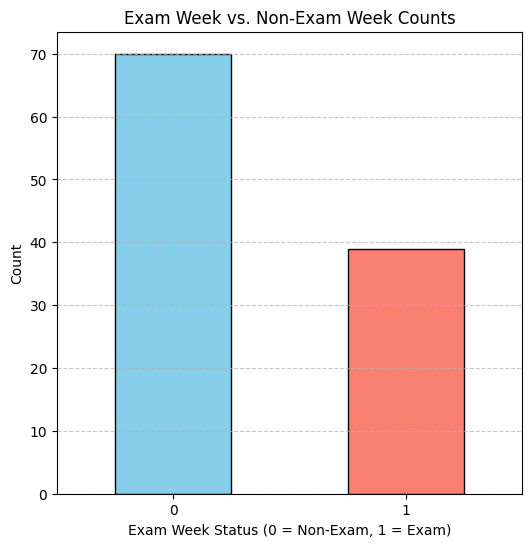

In [33]:
exam_week_counts = data['exam_week'].value_counts()

# Plot the counts for exam_week (0: Non-Exam, 1: Exam)
plt.figure(figsize=(6, 6))
exam_week_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title("Exam Week vs. Non-Exam Week Counts")
plt.xlabel("Exam Week Status (0 = Non-Exam, 1 = Exam)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()